# プロダクト開発演習

## テーマ
高解像度の画像への変換

## 目的
低解像度画像を高解像度画像にするアップサンプリング

## データセット
cifar10,cifar100

## 簡単な設計
CIFAR-10 で低解像→高解像

- 入力：32×32 を一旦 16×16 に縮小し、32×32 に整形した **低解像の画像（LR）**
- 教師：データセットに入っている **32×32 の画像（HR）**
- 目的：**LR → HR** を再構成（MSE を最小化、PSNR で評価）

## ★独自の工夫
- 中間層が4層の場合と6層の場合のモデルを作成。
- パラメータ数、処理時間、結果がどのように変わるか比較・結果の考察を行った。

## 1. ライブラリの読み込み & 再現性


In [71]:
# import sys # 今回は使っていない

import os, math, random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms, utils
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# 乱数シード固定（再現性）
# 毎回同じ挙動とするため。比較実験をした結果を安定して得るため
SEED = 42
random.seed(SEED); np.random.seed(SEED)
torch.manual_seed(SEED); torch.cuda.manual_seed_all(SEED)

# デバイス設定(CPU or GPU) ※手元はCPU環境だけど一応
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DEVICE

'cpu'

## 2. 設定（ハイパーパラメータ）

In [72]:
CFG = dict(
    # バッチサイズ
    batch_size=128,
    # 学習データを回す回数
    epochs=15,              # 本当は15以上は欲しいけど、PCスペックが足りないので実装時は3
    # epochs=1,
    # 学習率
    lr=2e-3,
    # L2正則化の強さ(重みが大きくなりすぎないようにする)
    weight_decay=1e-5,
    # 低解像度画像(LR)のサイズ 半分の32→16
    low_size=16,
    # 高解像度画像(HR)のサイズ 元画像のまま32
    high_size=32,
    # 結果を保存するディレクトリ
    save_dir="./runs_baseline_ipynb"
)
os.makedirs(CFG["save_dir"], exist_ok=True)
CFG

{'batch_size': 128,
 'epochs': 15,
 'lr': 0.002,
 'weight_decay': 1e-05,
 'low_size': 16,
 'high_size': 32,
 'save_dir': './runs_baseline_ipynb'}

## 3. データ前処理（CIFAR-10 を LR/HR に分ける）

In [73]:
# 画像をPytorchのテンソル形式(チャンネル,高さ,幅)に変換
to_tensor = transforms.ToTensor()
# トレーニング用のデータセットとテスト用にのデータセットを用意
trainset = datasets.CIFAR10(root="./data", train=True, download=True, transform=to_tensor)
testset  = datasets.CIFAR10(root="./data", train=False, download=True, transform=to_tensor)

train_loader = DataLoader(trainset, batch_size=CFG["batch_size"], shuffle=True, num_workers=4, pin_memory=True)
test_loader  = DataLoader(testset,  batch_size=CFG["batch_size"], shuffle=False, num_workers=4, pin_memory=True)

# 低解像度画像(LR)を作成する関数
def make_low_res(x, low=16, high=32):
    # x: (B,3,32,32) in [0,1]
    # 低解像度画像を作成する
    lr_small = F.interpolate(x, size=(low, low), mode="bilinear", align_corners=False)
    # 低解像度画像を引き伸ばす(低解像度のまま、教師用の画像と同じ大きさにする)
    lr_up    = F.interpolate(lr_small, size=(high, high), mode="bilinear", align_corners=False)
    return lr_up, x  # (入力LR(拡大), 教師HR)


In [74]:
# # 低解像度画像(LR)と高解像度画像(HR)ができているか確認(学習時は不要なコード)
# import matplotlib.pyplot as plt

# # テストデータの先頭バッチを取得
# x, _ = next(iter(test_loader))  # x: (B, 3, 32, 32)
# lr_up, hr = make_low_res(x, low=16, high=32)

# # GPU環境の場合はCPUに戻す（matplotlibがGPUテンソルを扱えないため）
# lr_up = lr_up.cpu()
# hr = hr.cpu()

# # 表示する枚数を指定
# n = 5  # 表示したい枚数（5〜10くらいがおすすめ）

# plt.figure(figsize=(10, 4))
# for i in range(n):
#     # 高解像度画像（正解）
#     plt.subplot(2, n, i + 1)
#     plt.imshow(hr[i].permute(1, 2, 0))  # [C,H,W] → [H,W,C]
#     plt.axis('off')
#     plt.title("HR (original)")

#     # 低解像度画像（ぼやけ）
#     plt.subplot(2, n, n + i + 1)
#     plt.imshow(lr_up[i].permute(1, 2, 0))
#     plt.axis('off')
#     plt.title("LR (blurred)")

# plt.tight_layout()
# plt.show()


## 4. モデルの実装(3層モデル・6層モデル)

In [ ]:
# 畳み込を行う層とReLUを定義
def conv_block(ic, oc):
    return nn.Sequential(nn.Conv2d(ic, oc, 3, padding=1), nn.ReLU(inplace=True))

# 畳み込みオートエンコーダのモデル定義(★中間層6層Ver)
class CAE_6(nn.Module):
    def __init__(self):
        super().__init__()
        # Encoder: Conv→Conv→Pool→Conv
        self.e1 = conv_block(3, 64)    # 32x32 1層目
        self.e2 = conv_block(64, 128)  # 32x32 2層目
        self.pool = nn.MaxPool2d(2)    # 32→16 3層目 プーリングで次元削減
        self.e3 = conv_block(128, 128) # 16x16 (bottleneckとする) 4層目

        # Decoder: Upsample→Conv
        self.up = nn.Upsample(scale_factor=2, mode="nearest")  # 16→32 # 次元を戻す 5層目
        self.d1 = conv_block(128, 64) # 32x32 # Conv, Rel 6層目
        self.out = nn.Conv2d(64, 3, kernel_size=1)  # 32x32, 3ch 出力層

    def forward(self, x):
        x = self.e1(x)
        x = self.e2(x)
        x = self.pool(x)
        x = self.e3(x)
        x = self.up(x)
        x = self.d1(x)
        y = torch.sigmoid(self.out(x))  # 出力を[0,1]
        return y

# 畳み込みオートエンコーダのモデル定義(★中間層4層Ver)
class CAE_4(nn.Module):
    def __init__(self):
        super().__init__()
        # Encoder: Conv→Pool
        self.e1  = conv_block(3, 64)    # 1層目
        self.pool= nn.MaxPool2d(2)      # 2層目
        
        # Decoder: Upsample→Conv
        self.up  = nn.Upsample(scale_factor=2, mode="nearest")  # 3層目
        self.d1  = conv_block(64, 64)                           # 4層目
        self.out = nn.Conv2d(64, 3, kernel_size=1)              # 出力層

    def forward(self, x):
        x = self.e1(x)
        x = self.pool(x)
        x = self.up(x)
        x = self.d1(x)
        y = torch.sigmoid(self.out(x))
        return y

model6 = CAE_6().to(DEVICE)
model4 = CAE_4().to(DEVICE)

# モデルのパラメータ数を確認
print("6層モデルのパラメータ数:", sum(p.numel() for p in model6.parameters())) # 297,219
print("4層モデルのパラメータ数:", sum(p.numel() for p in model4.parameters())) # 38,915

6層モデルのパラメータ数: 297219
4層モデルのパラメータ数: 38915


## 5. 損失・最適化・指標（MSE / PSNR）

In [76]:
# 損失関数と最適化手法の設定
# 平均二乗誤差
criterion = nn.MSELoss()

# モデル別のoptimizer（学習率やweight_decayはCFGを利用）
optimizers = {
    "CAE_4": torch.optim.Adam(model4.parameters(), lr=CFG["lr"], weight_decay=CFG["weight_decay"]),
    "CAE_6": torch.optim.Adam(model6.parameters(), lr=CFG["lr"], weight_decay=CFG["weight_decay"]),
}

# モデル名/オプティマイザ/ベスト値をモデル別に保持するためのユーティリティ ---
def get_model_name(model):
    if isinstance(model, CAE_4): return "CAE_4"
    if isinstance(model, CAE_6): return "CAE_6"
    return "UNKNOWN"

def get_optimizer(model):
    return optimizers[get_model_name(model)]

# PSNR：Peak Signal-to-Noise Ratio（ピーク信号対雑音比）を計算する関数
# MSEの逆数を対数で表した指標
# → 画像の画質(再現度)を評価する指標として使われる dBで表す(大体40dB以上で高画質とみなされる)
def psnr_from_mse(mse):
    # MSEが非常に小さい場合に、log10(∞)になってしまうのを防ぐ
    if mse <= 1e-12: return 99.0
    return 10 * math.log10(1.0 / mse)  # 入出力を[0,1]前提


## 6. 学習ループ & 検証

In [77]:
# 検証結果を保存するリストを返却
train_losses4, val_losses4, val_psnrs4 = [], [], []
train_losses6, val_losses6, val_psnrs6 = [], [], []

def get_current_lists(model):
    if isinstance(model, CAE_4):
        return train_losses4, val_losses4, val_psnrs4
    elif isinstance(model, CAE_6):
        return train_losses6, val_losses6, val_psnrs6
    else:
        raise ValueError("Unknown model type")

# モデル別のベスト（最小の検証損失）を保持
best_scores = {"CAE_4": float("inf"), "CAE_6": float("inf")}

# メモリ使用量と処理時間を抑える
@torch.no_grad()
# 検証用の関数
def validate(model):
    model.eval()
    total_loss, total_psnr, n = 0.0, 0.0, 0
    # テスト用データを使って評価
    for x, _ in test_loader:
        x = x.to(DEVICE)
        # 低解像度画像作成
        lr, hr = make_low_res(x, CFG["low_size"], CFG["high_size"])
        # 作成した低解像度画像をモデルに入力して、超解像度画像を生成
        sr = model(lr)
        # 損失計算
        loss = criterion(sr, hr)
        b = x.size(0)
        # バッチ内の合計損失、PSNRを計算(バッチサイズ×そのバッチの平均損失)
        total_loss += loss.item() * b
        total_psnr += psnr_from_mse(loss.item()) * b
        # 全サンプル数のカウント
        n += b
    # 全体の平均を計算（素直に平均を返す）
    return total_loss / n, total_psnr / n

# 学習ループの関数
def train_one_epoch(model, ep):
    model.train()
    run_loss, m = 0.0, 0
    for x, _ in train_loader:
        x = x.to(DEVICE)
        lr, hr = make_low_res(x, CFG["low_size"], CFG["high_size"])
        sr = model(lr)
        loss = criterion(sr, hr)
        # 誤差を逆伝播してパラメータを更新
        opt = get_optimizer(model)
        opt.zero_grad()
        loss.backward()
        opt.step()
        # 平均損失を計算する
        run_loss += loss.item() * x.size(0)
        m += x.size(0)

    # エポックごとの平均損失を計算
    tr = run_loss / m
    # 検証を実行
    va, va_psnr = validate(model)

    # 検証結果を保存（モデル別のリストへ）
    train_losses, val_losses, val_psnrs = get_current_lists(model)
    train_losses.append(tr); val_losses.append(va); val_psnrs.append(va_psnr)

    # ログ出力（今のモデル名も出す）  ※代入式は使わず、先に変数に取る
    model_name = get_model_name(model)
    last_psnr = val_psnrs[-1]
    print(f"[{model_name} | {ep:02d}/{CFG['epochs']}] "
          f"train={tr:.4f}  val={va:.4f}  PSNR={last_psnr:.2f}dB")

    # 最も小さい検証損失を出したモデルを保存（モデル別にファイル名を分ける）
    if va < best_scores[model_name]:
        best_scores[model_name] = va
        torch.save(model.state_dict(), os.path.join(CFG["save_dir"], f"best_{model_name}.pth"))

# 学習ループの実行(4層モデル)
for ep in range(1, CFG["epochs"] + 1):
    model = model4
    train_one_epoch(model, ep)

# 学習ループの実行(6層モデル)
for ep in range(1, CFG["epochs"] + 1):
    model = model6
    train_one_epoch(model, ep)


[CAE_4 | 01/15] train=0.0060  val=0.0035  PSNR=24.59dB
[CAE_4 | 02/15] train=0.0033  val=0.0039  PSNR=24.04dB
[CAE_4 | 03/15] train=0.0031  val=0.0030  PSNR=25.28dB
[CAE_4 | 04/15] train=0.0029  val=0.0029  PSNR=25.41dB
[CAE_4 | 05/15] train=0.0028  val=0.0027  PSNR=25.67dB
[CAE_4 | 06/15] train=0.0028  val=0.0027  PSNR=25.75dB
[CAE_4 | 07/15] train=0.0027  val=0.0028  PSNR=25.54dB
[CAE_4 | 08/15] train=0.0027  val=0.0026  PSNR=25.84dB
[CAE_4 | 09/15] train=0.0026  val=0.0026  PSNR=25.86dB
[CAE_4 | 10/15] train=0.0026  val=0.0028  PSNR=25.58dB
[CAE_4 | 11/15] train=0.0026  val=0.0026  PSNR=25.89dB
[CAE_4 | 12/15] train=0.0026  val=0.0025  PSNR=25.97dB
[CAE_4 | 13/15] train=0.0026  val=0.0025  PSNR=26.02dB
[CAE_4 | 14/15] train=0.0026  val=0.0025  PSNR=26.03dB
[CAE_4 | 15/15] train=0.0026  val=0.0027  PSNR=25.73dB
[CAE_6 | 01/15] train=0.0052  val=0.0025  PSNR=25.99dB
[CAE_6 | 02/15] train=0.0026  val=0.0024  PSNR=26.29dB
[CAE_6 | 03/15] train=0.0024  val=0.0023  PSNR=26.41dB
[CAE_6 | 0

## 7. 学習曲線の可視化

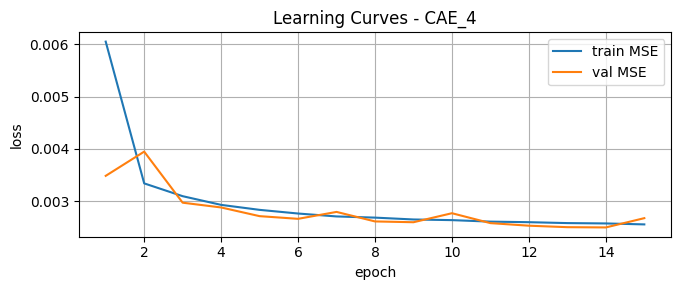

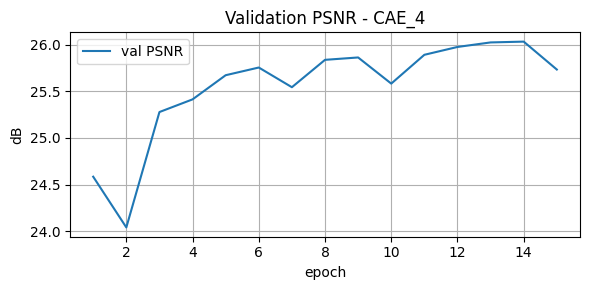

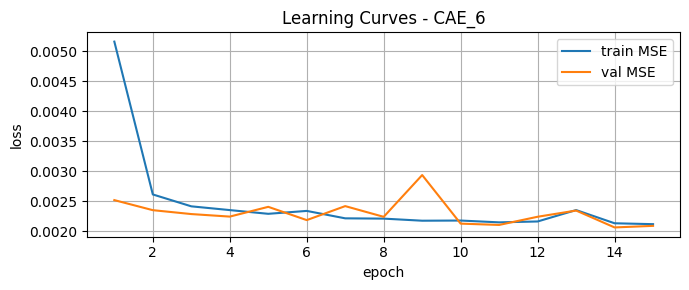

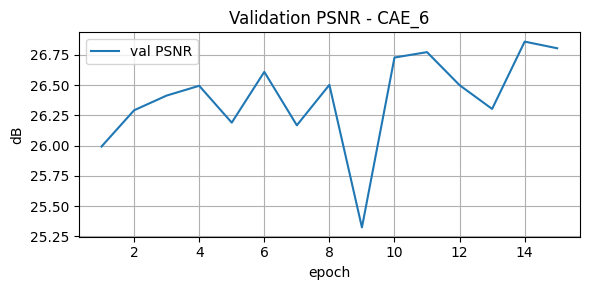

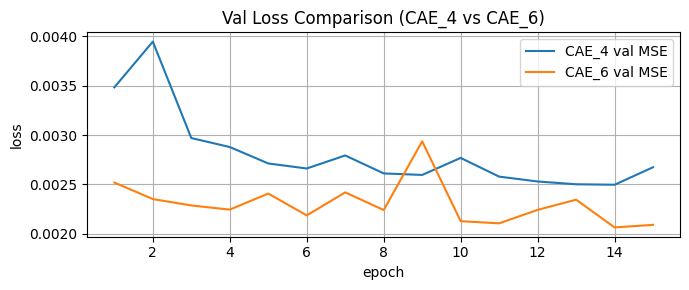

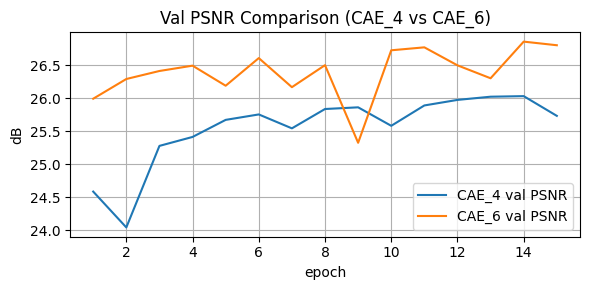

['best_CAE_4.pth',
 'compare_psnr_4v6.png',
 'demo_grid_4v6.png',
 'CAE_4',
 'CAE_6',
 'best_CAE_6.pth',
 'best_baseline.pth',
 'compare_curves_4v6.png',
 'psnr_baseline.png',
 'demo_grid_baseline.png',
 'curves_baseline.png']

In [ ]:
# 学習曲線の可視化（モデルごと & 比較用）
# モデル別に個別プロットして保存する
def plot_curves_per_model(model_name, train_losses, val_losses, val_psnrs):
    # モデル別の保存フォルダ（学習時のbest保存先と合わせる）
    save_dir = os.path.join(CFG["save_dir"], model_name)
    os.makedirs(save_dir, exist_ok=True)

    epochs_tr = range(1, len(train_losses) + 1)
    epochs_va = range(1, len(val_losses) + 1)
    epochs_ps = range(1, len(val_psnrs) + 1)

    # Loss 曲線（train / val）
    plt.figure(figsize=(7,3))
    plt.plot(epochs_tr, train_losses, label="train MSE")
    plt.plot(epochs_va, val_losses, label="val MSE")
    plt.xlabel("epoch"); plt.ylabel("loss"); plt.title(f"Learning Curves - {model_name}")
    plt.grid(True); plt.legend(); plt.tight_layout()
    plt.savefig(os.path.join(save_dir, f"curves_{model_name}.png"))
    plt.show()  # 画像を表示

    # PSNR 曲線（valのみ）
    plt.figure(figsize=(6,3))
    plt.plot(epochs_ps, val_psnrs, label="val PSNR")
    plt.xlabel("epoch"); plt.ylabel("dB"); plt.title(f"Validation PSNR - {model_name}")
    plt.grid(True); plt.legend(); plt.tight_layout()
    plt.savefig(os.path.join(save_dir, f"psnr_{model_name}.png"))
    plt.show()  # 画像を表示

# モデル別（4層/6層）の曲線を個別に出力
plot_curves_per_model("CAE_4", train_losses4, val_losses4, val_psnrs4)
plot_curves_per_model("CAE_6", train_losses6, val_losses6, val_psnrs6)

# 4層 vs 6層 の比較図（重ね描き）も作って保存
def plot_compare_4v6():
    root_dir = CFG["save_dir"]
    os.makedirs(root_dir, exist_ok=True)

    # エポック数が異なる可能性を考慮して、短い方に合わせる(基本同じだが念のため)
    n_loss = min(len(val_losses4), len(val_losses6))
    n_psnr = min(len(val_psnrs4), len(val_psnrs6))
    ep_loss = range(1, n_loss + 1)
    ep_psnr = range(1, n_psnr + 1)

    # Val Loss 比較
    plt.figure(figsize=(7,3))
    if n_loss > 0:
        plt.plot(ep_loss, val_losses4[:n_loss], label="CAE_4 val MSE")
        plt.plot(ep_loss, val_losses6[:n_loss], label="CAE_6 val MSE")
    plt.xlabel("epoch"); plt.ylabel("loss"); plt.title("Val Loss Comparison (CAE_4 vs CAE_6)")
    plt.grid(True); plt.legend(); plt.tight_layout()
    plt.savefig(os.path.join(root_dir, "compare_curves_4v6.png"))
    plt.show()

    # Val PSNR 比較
    plt.figure(figsize=(6,3))
    if n_psnr > 0:
        plt.plot(ep_psnr, val_psnrs4[:n_psnr], label="CAE_4 val PSNR")
        plt.plot(ep_psnr, val_psnrs6[:n_psnr], label="CAE_6 val PSNR")
    plt.xlabel("epoch"); plt.ylabel("dB"); plt.title("Val PSNR Comparison (CAE_4 vs CAE_6)")
    plt.grid(True); plt.legend(); plt.tight_layout()
    plt.savefig(os.path.join(root_dir, "compare_psnr_4v6.png"))
    plt.show()

plot_compare_4v6()

# 出力確認
os.listdir(CFG["save_dir"])

## 8. 予測デモ（LR → 出力SR → HR を1枚に）

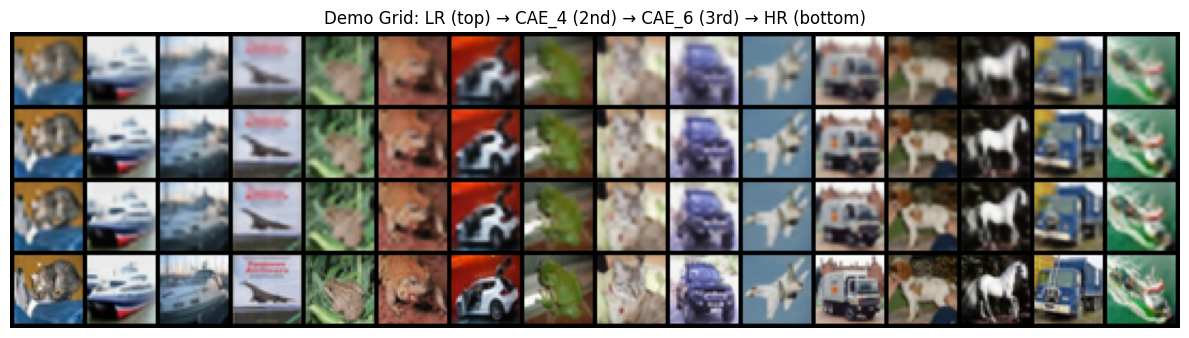

'./runs_baseline_ipynb/demo_grid_4v6.png'

In [79]:
@torch.no_grad()
def save_demo_grid_4v6(nshow=16):
    # 先程学習させたモデルを読み込む（モデルごとに別ファイル）
    m4 = CAE_4().to(DEVICE)
    m4.load_state_dict(torch.load(os.path.join(CFG["save_dir"], "best_CAE_4.pth"), map_location=DEVICE))
    m4.eval()

    m6 = CAE_6().to(DEVICE)
    m6.load_state_dict(torch.load(os.path.join(CFG["save_dir"], "best_CAE_6.pth"), map_location=DEVICE))
    m6.eval()

    # テストデータの先頭バッチを1度だけ取得 → 両モデルで同じデータを使う
    x, _ = next(iter(test_loader))
    x = x[:nshow].to(DEVICE)

    # 低解像度画像を作り、SRを両モデルで生成
    lr, hr = make_low_res(x, CFG["low_size"], CFG["high_size"])
    sr4 = m4(lr)
    sr6 = m6(lr)

    # グリッドを作成（上から LR → CAE_4 → CAE_6 → HR）
    grid = torch.cat([lr.cpu(), sr4.cpu(), sr6.cpu(), hr.cpu()], dim=0)  # nshow*4枚
    out_path = os.path.join(CFG["save_dir"], "demo_grid_4v6.png")
    utils.save_image(grid, out_path, nrow=nshow)
    return out_path

# 画像を保存して表示
demo_path = save_demo_grid_4v6(nshow=16)

from PIL import Image
img = Image.open(demo_path)
plt.figure(figsize=(12, 9))
plt.imshow(img)
plt.axis('off')
plt.title('Demo Grid: LR (top) → CAE_4 (2nd) → CAE_6 (3rd) → HR (bottom)')
plt.tight_layout()
plt.show()

demo_path

# @torch.no_grad()
# def save_demo_grid():
#     # 先程学習させたモデルを読み込む
#     model.load_state_dict(torch.load(os.path.join(CFG["save_dir"], "best_baseline.pth"), map_location=DEVICE))
#     model.eval()
#     # テストデータの先頭バッチを取得 16枚だけ使ってみる
#     x, _ = next(iter(test_loader))
#     x = x[:16].to(DEVICE)
#     lr, hr = make_low_res(x, CFG["low_size"], CFG["high_size"])
#     sr = model(lr)
#     grid = torch.cat([lr.cpu(), sr.cpu(), hr.cpu()], dim=0)  # 16*3=48枚 (上:LR 中:SR 下:HR)
#     out_path = os.path.join(CFG["save_dir"], "demo_grid_baseline.png")
#     utils.save_image(grid, out_path, nrow=16)
#     return out_path

# demo_path = save_demo_grid()

# # 画像を表示
# # 上から下にかけて、画像の解像度が上がっていれば成功
# from PIL import Image
# img = Image.open(demo_path)
# plt.figure(figsize=(12, 8))
# plt.imshow(img)
# plt.axis('off')
# plt.title('Demo Grid: LR (top) → SR (middle) → HR (bottom)')
# plt.tight_layout()
# plt.show()

# demo_path

## 9. 結果についての考察


### 総括
本課題では、CIFAR-10データセットを用いて、低解像度（16×16）画像を高解像度（32×32）に変換する畳み込みオートエンコーダ（CAE）を実装した。  
モデルは2種類用意し、中間層4層と6層をそれぞれ用意し、
Epoch数15、学習率2e-3、MSELossを用いて訓練した結果、結果は下記のとおりとなった。

| モデル名 | エポック数 | 最良Train Loss | 最良Val Loss | 最良PSNR (dB) | 特徴・傾向 |
|:-----------|:------------:|:---------------:|:---------------:|:---------------:|:------------|
| CAE_4（中間層4層） | 15 | 0.0026 | 0.0025 | 26.03 | 初期に急速収束し、10epoch以降は安定。ぼやけは残るが過学習は少ない。|
| CAE_6（中間層6層） | 15 | 0.0021 | 0.0021 | 26.86 | より深い層構造により表現力が向上。文字や細部の再現(動物の模様等)が改善し、PSNRが約+0.8dB上昇。色が濃いところ、エッジがより再現されているように見えた。ただしパラメータ数が中間層4層より約7.6倍あるためか過学習の傾向が少し見られた |

### 2つのモデルを比較した結果分かったこと
- CAE_6はCAE_4よりも約0.8dB PSNRが高く、損失も最初から安定して小さい。  
- 層を増やすことで、低解像度画像から高解像度画像へのマッピング能力が強化された。  
- 一方で、層を増やすことで訓練時間やメモリ負荷がかなり増加し、軽い過学習傾向(検証データのみ結果が悪化)も見られる。
    - (中間層)6層モデルのパラメータ数は297219、4層モデルのパラメータ数は38915と約7.6倍の差がある
    - 訓練時間は4層が約39分だったのに対して6層は約123分かかった。パラメータ数と比例はしないが処理時間も約3倍強かかった。
- 処理時間と求める結果に応じて処理の軽さと正確性を天秤に掛ける必要がある。

### 教師画像の完全再現まで至らなかった理由の考察と改善策
1. ダウンサンプリング時に情報欠損
    - 入力時に32×32を16×16した際に失われた情報は戻らない
    - 動物の模様など、結果的に教師画像とは異なる模様となるパターンがあった
2. 過学習してしまった
    - 過学習防止：Batch Normalizationの導入・Dropoutの導入
    - 学習データの増加：データ拡張(反転・回転等)

<!-- Best is kernel=4, last dropout? -->